# RL with a cartpole

https://www.digikey.com/en/maker/projects/intro-to-reinforcement-learning-using-gymnasium-and-stable-baselines3/28c6602f5d1e4ce1b5a90642a1ac7efc

https://github.com/ShawnHymel/reinforcement-learning-demos/blob/main/rl-demo-cartpole.ipynb

In [2]:
# python -m pip install gymnasium==0.28.1
# python -m pip install stable-baselines3[extra]==2.0.0a1

In [ ]:
import gymnasium as gym
import stable_baselines3 as sb3
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Check versions

print(f"gym version: {gym.__version__}")
print(f"cv2 version: {cv2.__version__}")

gym version: 0.28.1
cv2 version: 4.12.0


In [2]:
# Create the environment
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Get one reset + render to define frame shape
obs, info = env.reset()
frame = env.render()

/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(400, 600, 3)


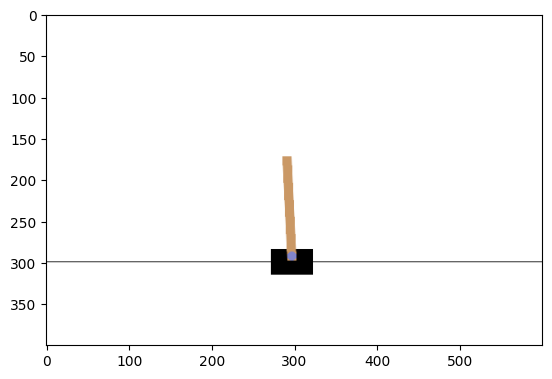

In [15]:
print(frame.shape)
plt.imshow(frame)

[-0.00297419 -0.22745578 -0.04133222  0.30523676] 1.0 False False {}


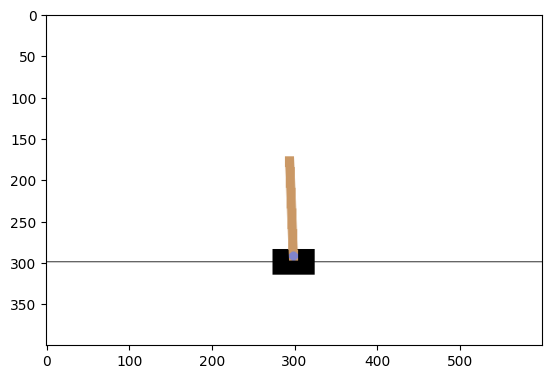

In [3]:
obs, reward, terminated, truncated, info = env.step(0) 
print(obs, reward, terminated, truncated, info)
frame = env.render()
plt.imshow(frame)

In [4]:
# Function that tests the model in the given environment
def test_model(env, model, video=None, msg=None):

    # Reset environment
    obs, info = env.reset()
    frame = env.render()
    ep_len = 0
    ep_rew = 0

    # Run episode until complete
    while True:

        # Provide observation to policy to predict the next action
        action, _ = model.predict(obs)

        # Perform action, update total reward
        obs, reward, terminated, truncated, info = env.step(action)
        ep_rew += reward

        # Record frame to video
        if video:
            frame = env.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = cv2.putText(
                frame,                    # Image
                msg,                      # Text to add
                (10, 25),                 # Origin of text in image
                cv2.FONT_HERSHEY_SIMPLEX, # Font
                1,                        # Font scale
                (0, 0, 0,),               # Color
                2,                        # Thickness
                cv2.LINE_AA               # Line type
            )
            video.write(frame)

        # Increase step counter
        ep_len += 1

        # Check to see if episode has ended
        if terminated or truncated:
            return ep_len, ep_rew

In [6]:
# Model that just predicts random actions
class DummyModel():

    # Save environment
    def __init__(self, env):
        self.env = env

    # Always output random action regardless of observation
    def predict(self, obs):
        action = self.env.action_space.sample()
        return action, None

In [8]:
# Recorder settings
FPS = 30
FOURCC = cv2.VideoWriter.fourcc('m', 'p', '4', 'v')
VIDEO_FILENAME = "/output/1-random-joseph.mp4"

# Use frame from environment to compute resolution
width = frame.shape[1]
height = frame.shape[0]

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Try running a few episodes with the environment and random actions
dummy_model = DummyModel(env)
for ep in range(5):
    ep_len, ep_rew = test_model(env, dummy_model, video, f"Random, episode {ep}")
    print(f"Episode {ep} | length: {ep_len}, reward: {ep_rew}")

# Close the video writer
video.release()

Episode 0 | length: 10, reward: 10.0
Episode 1 | length: 85, reward: 85.0
Episode 2 | length: 33, reward: 33.0
Episode 3 | length: 24, reward: 24.0
Episode 4 | length: 38, reward: 38.0


In [10]:
# Initialize model
model = sb3.DQN(
    'MlpPolicy',
    env,
    learning_rate=0.0001,       # Learning rate of neural network (default: 0.0001)
    buffer_size=1000000,        # Size of the replay buffer (default: 1000000)
    learning_starts=1000,       # Number of steps to take before learning (default: 50000)
    batch_size=32,              # Minibatch size for each gradient update (default: 32)
    gamma=0.99,                 # Discount factor (default: 0.99)
    train_freq=256,             # Number of steps to take before update (default: 4)
    gradient_steps=128,         # Number of gradient steps after each rollout (default: 1)
    target_update_interval=10,  # Number of steps to take before target network update (default: 10000)
    policy_kwargs={'net_arch': [256, 256]}, # 2 hidden layers, 1 output layer (default: [64, 64])
    verbose=0                   # Print training metrics (default: 0)
)

In [11]:
# Training and testing hyperparameters
NUM_ROUNDS = 20
NUM_TRAINING_STEPS_PER_ROUND = 5000
NUM_TESTS_PER_ROUND = 100
MODEL_FILENAME_BASE = "cartpole-dqn"
VIDEO_FILENAME = "2-training.mp4"

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Train and test the model for a number of rounds
avg_ep_lens = []
avg_ep_rews = []
for rnd in range(NUM_ROUNDS):

    # Train the model
    model.learn(total_timesteps=NUM_TRAINING_STEPS_PER_ROUND)

    # Save the model
    model.save(f"{MODEL_FILENAME_BASE}_{rnd}")

    # Test the model in several episodes
    avg_ep_len = 0
    avg_ep_rew = 0
    for ep in range(NUM_TESTS_PER_ROUND):

        # Only record the first test
        if ep == 0:
            ep_len, ep_rew = test_model(env, model, video, f"Round {rnd}")
        else:
            ep_len, ep_rew = test_model(env, model)

        # Accumulate average length and reward
        avg_ep_len += ep_len
        avg_ep_rew += ep_rew

    # Record and dieplay average episode length and reward
    avg_ep_len /= NUM_TESTS_PER_ROUND
    avg_ep_lens.append(avg_ep_len)
    avg_ep_rew /= NUM_TESTS_PER_ROUND
    avg_ep_rews.append(avg_ep_rew)
    print(f"Round {rnd} | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")

# Close the video writer
video.release()

Round 0 | average test length: 155.38, average test reward: 155.38
Round 1 | average test length: 104.09, average test reward: 104.09
Round 2 | average test length: 204.33, average test reward: 204.33
Round 3 | average test length: 121.97, average test reward: 121.97
Round 4 | average test length: 131.69, average test reward: 131.69
Round 5 | average test length: 111.48, average test reward: 111.48
Round 6 | average test length: 161.23, average test reward: 161.23
Round 7 | average test length: 103.72, average test reward: 103.72
Round 8 | average test length: 138.86, average test reward: 138.86
Round 9 | average test length: 231.99, average test reward: 231.99
Round 10 | average test length: 431.82, average test reward: 431.82
Round 11 | average test length: 208.0, average test reward: 208.0
Round 12 | average test length: 151.16, average test reward: 151.16
Round 13 | average test length: 180.34, average test reward: 180.34
Round 14 | average test length: 221.07, average test reward:

Text(0.5, 23.52222222222222, 'Round')

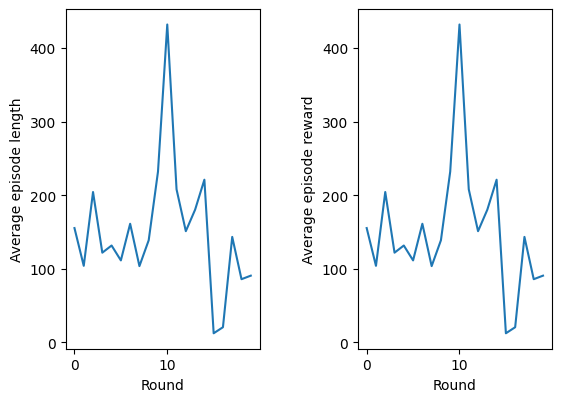

In [12]:
# Plot average test episode lengths and rewards for each round
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)
axs[0].plot(avg_ep_lens)
axs[0].set_ylabel("Average episode length")
axs[0].set_xlabel("Round")
axs[1].plot(avg_ep_rews)
axs[1].set_ylabel("Average episode reward")
axs[1].set_xlabel("Round")

In [16]:
# Model and video settings
MODEL_FILENAME = "dqn_files/cartpole-dqn_19"
VIDEO_FILENAME = "output/3-testing.mp4"

# Load the model
model = sb3.DQN.load(MODEL_FILENAME)

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Test the model
ep_len, ep_rew = test_model(env, model, video, MODEL_FILENAME)
print(f"Episode length: {ep_len}, reward: {ep_rew}")

# Close the video writer
video.release()

Episode length: 95, reward: 95.0


In [17]:
# We're done with the environment
env.close()